## Reproduction of *Deep Residual Learning for Image Recognition*

Paper here: https://arxiv.org/pdf/1512.03385

In [119]:
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [121]:
def kaiming_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [122]:
import torch
import torch.nn as nn

def kaiming_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

class ResidualBlockConv(nn.Module):
    def __init__(
            self, 
            in_channels=None,
            out_channels=None,
            num_layers=2, 
            kernel_size=3,
            projection=False,
            activation=nn.ReLU()
    ) -> None:
        super(ResidualBlockConv, self).__init__()
        assert in_channels is not None, "Input channels is set to None"
        assert out_channels is not None, "Output channels is set to None"

        self.projection = projection
        self.layers = nn.Sequential()
        if self.projection:
            self.downsample_conv = nn.Conv2d(
                kernel_size=1, 
                in_channels=in_channels,
                out_channels=out_channels,
                stride=2
            )
            self.downsample_bn = nn.BatchNorm2d(out_channels)  

        layers = []
        for i in range(num_layers + 1):
            if i == 0 and self.projection:
                layers.append(nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=1,
                    stride=2
                ))
                layers.append(nn.BatchNorm2d(out_channels))  
            elif i == num_layers - 1:
                layers.append(activation)
            else:
                layers.append(nn.Conv2d(
                    in_channels=out_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=1
                ))
                layers.append(nn.BatchNorm2d(out_channels)) 
        
        self.layers = nn.Sequential(*layers)
        self.last_relu = activation

    def downsample(self, x):
        if self.downsample_conv is not None:
            return self.downsample_bn(self.downsample_conv(x))  
        return x

    def forward(self, x):
        residual = x
        
        out = self.layers(x)
             
        # check if we need to downsample
        if self.projection:
            residual = self.downsample(residual)
        
        # perform the residual mapping
        out += residual
        out = self.last_relu(out)
        return out


In [123]:
class ResNet(nn.Module):
    def __init__(
            self,
            net_blocks,
            num_classes=10,
            activation=nn.ReLU(),
        ) -> None:
        super(ResNet, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        ))
        self.layers.append(nn.BatchNorm2d(64)) 
        self.layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.layers.append(activation)
        self.layers.append(self._make_block(net_blocks[0], 64, 64))
        self.layers.append(self._make_block(net_blocks[1], 64, 128))
        self.layers.append(self._make_block(net_blocks[2], 128, 256))
        self.layers.append(self._make_block(net_blocks[3], 256, 512))
        self.layers.append(nn.AdaptiveAvgPool2d(output_size=(1, 1)))
        self.layers.append(nn.Flatten(start_dim=1))
        self.layers.append(nn.Linear(in_features=512, out_features=num_classes))

        self.apply(kaiming_init)
    
    def _make_block(self, num_blocks, in_channels, out_channels):
        new_block = nn.Sequential()
        for i in range(num_blocks):
            if in_channels != out_channels:
                if i == 0:
                    new_block.append(ResidualBlockConv(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        projection=True
                    ))
                else:
                    new_block.append(ResidualBlockConv(
                        in_channels=out_channels,
                        out_channels=out_channels
                    ))
            else:
                new_block.append(ResidualBlockConv(
                    in_channels=out_channels,
                    out_channels=out_channels
                ))

        return new_block

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


Create a plain network to constrast the residual learning net with a plain deep one

In [124]:
class PlainNet(nn.Module):
    def __init__(
            self,
            blocks,
            num_classes=10,
            activation=nn.ReLU()
        ) -> None:
        super(PlainNet, self).__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        ))

        self.layers.append(nn.BatchNorm2d(64)) 
        self.layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.layers.append(activation)

        for _ in range(blocks[0]):
            self.layers.append(nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                padding=1
            ))
            self.layers.append(nn.BatchNorm2d(64))  
            self.layers.append(activation)
        
        self.layers.append(nn.Conv2d(
            in_channels=64, 
            out_channels=128,
            kernel_size=3, 
            stride=2,
            padding=1
        ))
        self.layers.append(nn.BatchNorm2d(128))  
        self.layers.append(activation)

        for _ in range(blocks[1]):
            self.layers.append(nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                padding=1
            ))
            self.layers.append(nn.BatchNorm2d(128))  
            self.layers.append(activation)
        
        self.layers.append(nn.Conv2d(
            in_channels=128, 
            out_channels=256,
            kernel_size=3, 
            stride=2,
            padding=1
        ))
        self.layers.append(nn.BatchNorm2d(256))  
        self.layers.append(activation)

        for _ in range(blocks[2]):
            self.layers.append(nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1
            ))
            self.layers.append(nn.BatchNorm2d(256))  
            self.layers.append(activation)

        self.layers.append(nn.Conv2d(
            in_channels=256, 
            out_channels=512,
            kernel_size=3, 
            stride=2,
            padding=1
        ))
        self.layers.append(nn.BatchNorm2d(512))  
        self.layers.append(activation)

        for _ in range(blocks[3]):
            self.layers.append(nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,
                padding=1
            ))
            self.layers.append(nn.BatchNorm2d(512))  
            self.layers.append(activation)

        self.layers.append(nn.AdaptiveAvgPool2d(
            output_size=(1, 1)
        ))

        self.layers.append(nn.Flatten(start_dim=1))

        self.layers.append(nn.Linear(
            in_features=512,
            out_features=num_classes
        ))
        
        self.apply(kaiming_init)

    def forward(self, x):
        out = x 
        for layer in self.layers:
            out = layer(out)
        return out 

In [125]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.transforms import v2
from torchvision.utils import make_grid
from yaml import load, Loader

In [126]:
g = torch.manual_seed(1337)

In [127]:
with open('config.yaml', 'r') as f:
    config = load(f, Loader)

num_classs = config['num_classes']
starting_lr = config['starting_lr']
input_size = config['input_size']
epochs = config['epochs']
batch_size = config['batch_size']

In [128]:
transformation_train = v2.Compose([
    v2.ToImage(),
    v2.RandomCrop(32, padding=4, padding_mode='reflect'),
    v2.RandomHorizontalFlip(p=0.2),
    v2.RandomRotation(degrees=90),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=True),
])

In [129]:
transformation_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=True),
])

In [149]:
cifar10_train = CIFAR10('data/', train=True, transform=transformation_train, download=True)
cifar10_test = CIFAR10('data/', transform=transformation_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [131]:
trainloader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [132]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [133]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


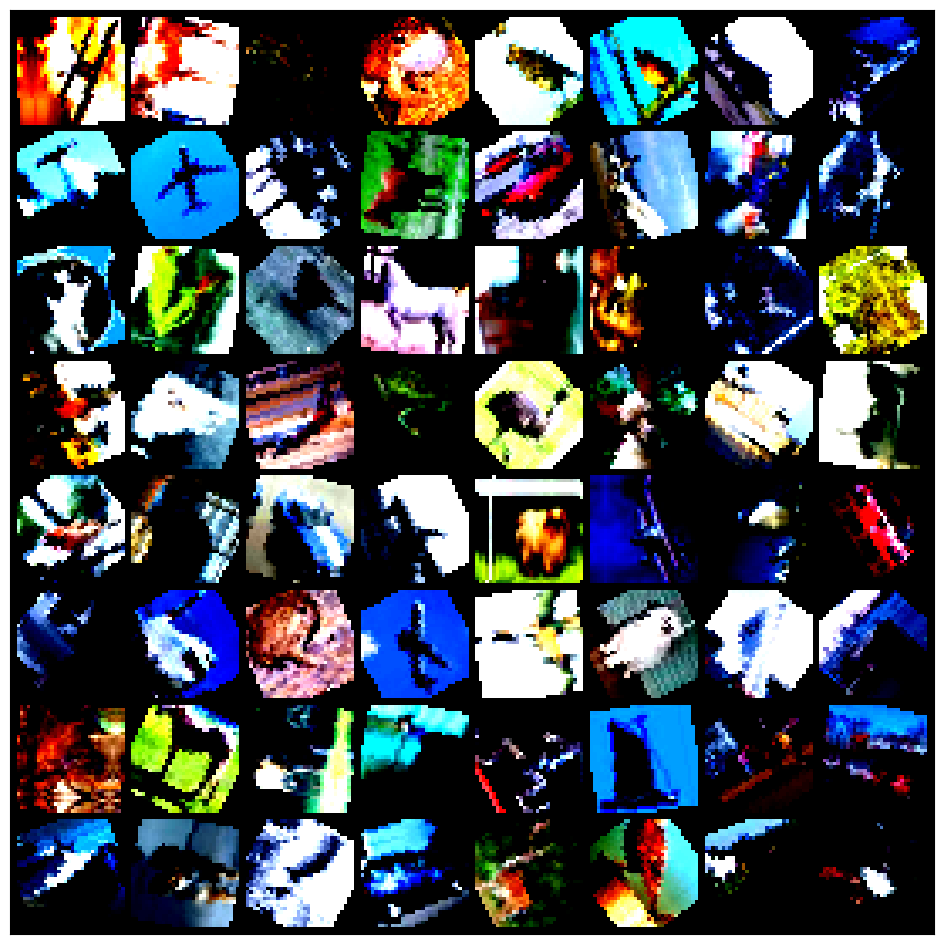

In [134]:
show_batch(trainloader)

In [135]:
model = PlainNet([2, 3, 3, 3]).to(device=device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 35], gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [179]:
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [136]:
def evaluate(model, valdata):
    with torch.no_grad():
        model.eval()
        validation_loss = []
        for i, data in enumerate(valdata):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            validation_loss.append(val_loss.item())
        return np.array(validation_loss).mean()

In [137]:
def test_accuracy(model, valloader, verbose=False):
    model.eval() 
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    if verbose: print(f'Accuracy of the model on the validation set: {accuracy:.2f}%')
    return accuracy

In [177]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
training_loss = []
validation_loss = []
accuracy = []

In [180]:

for epoch in range(epochs):

    step_loss = []
    running_loss = 0.0
    model.train()

    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        nn.utils.clip_grad_value_(model.parameters(), 0.01)

        optimizer.step()
    
        step_loss.append(loss.item())

    training_loss.append(np.array(step_loss).mean())

    val_loss = evaluate(model, valloader)
    acc = test_accuracy(model, valloader)

    validation_loss.append(val_loss)
    accuracy.append(acc)

    scheduler.step(val_loss)
    
    print(f'\n Iteration {epoch+1}/{epochs}: train loss {training_loss[-1]:.4f}, val loss {val_loss:.4f}, val accuracy {acc:.2f}%, lr {get_lr(optimizer)}')



 Iteration 1/75: train loss 0.6693, val loss 0.4795, val accuracy 83.00%, lr 0.003

 Iteration 2/75: train loss 0.6713, val loss 0.4734, val accuracy 83.30%, lr 0.003

 Iteration 3/75: train loss 0.6701, val loss 0.4812, val accuracy 83.08%, lr 0.003

 Iteration 4/75: train loss 0.6681, val loss 0.4709, val accuracy 83.76%, lr 0.003

 Iteration 5/75: train loss 0.6702, val loss 0.4743, val accuracy 83.63%, lr 0.003

 Iteration 6/75: train loss 0.6651, val loss 0.4699, val accuracy 83.53%, lr 0.003

 Iteration 7/75: train loss 0.6673, val loss 0.4787, val accuracy 83.40%, lr 0.003

 Iteration 8/75: train loss 0.6646, val loss 0.4727, val accuracy 83.57%, lr 0.003

 Iteration 9/75: train loss 0.6608, val loss 0.4706, val accuracy 83.43%, lr 0.003

 Iteration 10/75: train loss 0.6645, val loss 0.4637, val accuracy 83.71%, lr 0.003

 Iteration 11/75: train loss 0.6571, val loss 0.4681, val accuracy 83.77%, lr 0.003

 Iteration 12/75: train loss 0.6598, val loss 0.4688, val accuracy 83.76%

KeyboardInterrupt: 

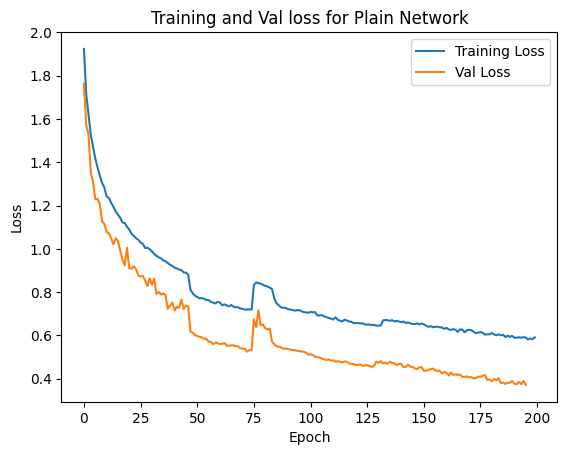

In [204]:
plt.title('Training and Val loss for Plain Network')
plt.plot(np.arange(len(training_loss)), training_loss, label='Training Loss')
plt.plot(np.arange(len(validation_loss)), validation_loss, label='Val Loss')
plt.savefig('plainnet.png')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [186]:
model_res = ResNet([3, 4, 6, 3]).to(device=device)
criterion = nn.CrossEntropyLoss()

In [199]:
optimizer = optim.SGD(model_res.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[35])

In [187]:
training_loss_res = []
validation_loss_res = []
accuracy_res = []

In [200]:

for epoch in range(epochs):

    step_loss = []
    running_loss = 0.0
    model_res.train()

    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = model_res(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # nn.utils.clip_grad_value_(model.parameters(), 0.1)

        optimizer.step()
    
        step_loss.append(loss.item())

    training_loss_res.append(np.array(step_loss).mean())

    val_loss = evaluate(model_res, valloader)
    acc = test_accuracy(model_res, valloader)

    validation_loss_res.append(val_loss)
    accuracy_res.append(acc)

    scheduler.step()
     
    print(f'\n Iteration {epoch+1}/{epochs}: train loss {training_loss_res[-1]:.4f}, val loss {val_loss:.4f}, val accuracy {acc:.2f}%, lr {get_lr(optimizer)}')



 Iteration 1/75: train loss 0.6697, val loss 0.4505, val accuracy 84.17%, lr 0.001

 Iteration 2/75: train loss 0.6602, val loss 0.4383, val accuracy 84.74%, lr 0.001

 Iteration 3/75: train loss 0.6488, val loss 0.4342, val accuracy 84.73%, lr 0.001

 Iteration 4/75: train loss 0.6494, val loss 0.4546, val accuracy 84.07%, lr 0.001

 Iteration 5/75: train loss 0.6458, val loss 0.4696, val accuracy 83.88%, lr 0.001

 Iteration 6/75: train loss 0.6368, val loss 0.4185, val accuracy 85.17%, lr 0.001

 Iteration 7/75: train loss 0.6400, val loss 0.4192, val accuracy 85.38%, lr 0.001

 Iteration 8/75: train loss 0.6328, val loss 0.4159, val accuracy 85.32%, lr 0.001

 Iteration 9/75: train loss 0.6339, val loss 0.4248, val accuracy 85.11%, lr 0.001

 Iteration 10/75: train loss 0.6239, val loss 0.4045, val accuracy 85.81%, lr 0.001

 Iteration 11/75: train loss 0.6243, val loss 0.4077, val accuracy 85.84%, lr 0.001

 Iteration 12/75: train loss 0.6185, val loss 0.3947, val accuracy 86.35%

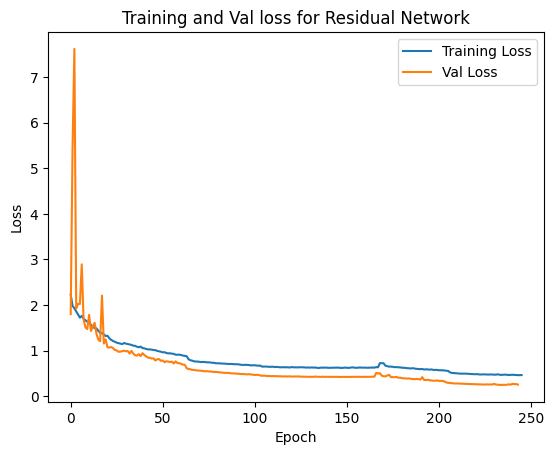

In [211]:
plt.title('Training and Val loss for Residual Network')
plt.plot(np.arange(len(training_loss_res)), training_loss_res, label='Training Loss')
plt.plot(np.arange(len(validation_loss_res)), validation_loss_res, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('resnet.png');

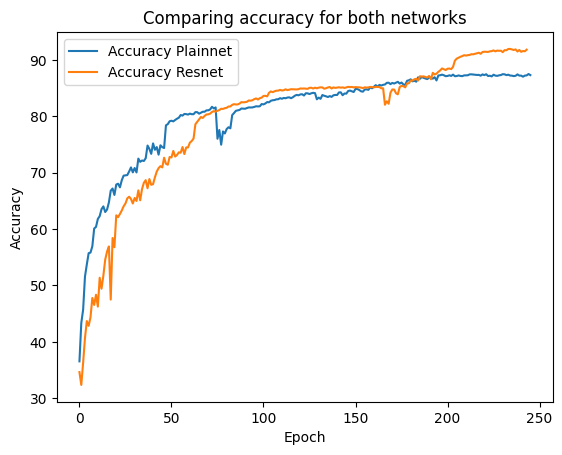

In [225]:
plt.title('Comparing accuracy for both networks')
plt.plot(np.arange(len(accuracy)), accuracy, label='Accuracy Plainnet')
plt.plot(np.arange(len(accuracy_res)), accuracy_res, label='Accuracy Resnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('comparison.png');